In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import copy

import pyproj
print(pyproj.datadir.get_data_dir())
pyproj.datadir.set_data_dir('/usr/local/anaconda3/envs/info615/share/proj')

/usr/local/anaconda3/envs/py36/share/proj


/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
#Load census data
df = pd.read_csv('data/raw_data/LA_COUNTY_DECENNIALPL2020.P2_2022-04-20T180930/DECENNIALPL2020.P2_data_with_overlays_2022-04-20T180904.csv', skiprows = [1])
df.drop(0, inplace = True)

#Split out relevant part of GEOID
df['GEOID20'] = df['GEO_ID'].str.split('US').str[-1]

#Convert to numeric
cols_numeric = [col for col in df.columns if col not in ['GEO_ID','GEOID20', 'NAME']]
df[cols_numeric] = df[cols_numeric].apply(pd.to_numeric)

df.head()


,GEO_ID,NAME,P2_001N,P2_002N,P2_003N,P2_004N,P2_005N,P2_006N,P2_007N,P2_008N,...,P2_065N,P2_066N,P2_067N,P2_068N,P2_069N,P2_070N,P2_071N,P2_072N,P2_073N,GEOID20
1,1000000US060371011101001,"Block 1001, Block Group 1, Census Tract 1011.1...",81,22,59,57,39,6,0,8,...,0,0,0,0,0,0,0,0,0,060371011101001
2,1000000US060371011101002,"Block 1002, Block Group 1, Census Tract 1011.1...",75,10,65,58,49,1,1,7,...,0,0,0,0,0,0,0,0,0,060371011101002
3,1000000US060371011101003,"Block 1003, Block Group 1, Census Tract 1011.1...",76,25,51,45,45,0,0,0,...,0,0,0,0,0,0,0,0,0,060371011101003
4,1000000US060371011101004,"Block 1004, Block Group 1, Census Tract 1011.1...",155,28,127,119,108,0,0,11,...,0,0,0,0,0,0,0,0,0,060371011101004
5,1000000US060371011101005,"Block 1005, Block Group 1, Census Tract 1011.1...",138,35,103,96,86,3,0,7,...,0,0,0,0,0,0,0,0,0,060371011101005


In [3]:
#Load block shapefile for all of state
block_gdf_all = gpd.read_file('data/raw_data/tl_2020_06_tabblock20/tl_2020_06_tabblock20.shp')
#Extract counties
block_gdf = block_gdf_all[block_gdf_all['COUNTYFP20'] == '037']
del block_gdf_all
block_gdf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,HOUSING20,POP20,geometry
77,06,037,900504,3015,060379005043015,Block 3015,G5040,None,None,None,S,54383,0,+34.6720867,-118.1059857,55,163,"POLYGON ((-118.10792 34.67178, -118.10792 34.6..."
78,06,037,900509,3006,060379005093006,Block 3006,G5040,None,None,None,S,32419,0,+34.6732813,-118.0910377,37,160,"POLYGON ((-118.09193 34.67415, -118.09107 34.6..."
79,06,037,103102,1002,060371031021002,Block 1002,G5040,None,None,None,S,68353,0,+34.2639661,-118.3003244,94,275,"POLYGON ((-118.30269 34.26386, -118.30269 34.2..."
122,06,037,134303,3001,060371343033001,Block 3001,G5040,None,None,None,S,18550,0,+34.2069872,-118.6124548,19,62,"POLYGON ((-118.61361 34.20726, -118.61359 34.2..."
123,06,037,131900,1002,060371319001002,Block 1002,G5040,None,None,None,S,25351,0,+34.2061693,-118.5037065,33,90,"POLYGON ((-118.50418 34.20484, -118.50415 34.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519679,06,037,480602,3007,060374806023007,Block 3007,G5040,None,None,None,S,2717,380,+34.1181633,-118.1666301,0,0,"POLYGON ((-118.16822 34.11777, -118.16802 34.1..."
519681,06,037,301801,3003,060373018013003,Block 3003,G5040,None,None,None,S,12448,3382,+34.1586969,-118.2567251,0,0,"POLYGON ((-118.25797 34.15874, -118.25794 34.1..."
519682,06,037,990200,0003,060379902000003,Block 0003,G5040,None,None,None,S,0,608916,+34.0062987,-118.5742060,0,0,"POLYGON ((-118.58286 34.03343, -118.57103 34.0..."
519691,06,037,530102,3014,060375301023014,Block 3014,G5040,None,None,None,S,2204,0,+34.0134620,-118.1242667,0,0,"POLYGON ((-118.12502 34.01370, -118.12449 34.0..."


In [4]:
#Merge
race_gdf = block_gdf.merge(df, on = 'GEOID20', how = 'left')

#Check - should return nothing
race_gdf[race_gdf['geometry'].isna()]

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,...,P2_064N,P2_065N,P2_066N,P2_067N,P2_068N,P2_069N,P2_070N,P2_071N,P2_072N,P2_073N


<AxesSubplot:>

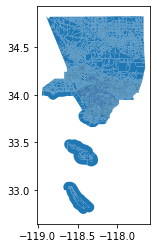

In [5]:
race_gdf.plot()

### Clip at shoreline

In [6]:
county_gdf = gpd.read_file('data/raw_data/LA_County_City_Boundaries/LA_County_City_Boundaries.shp')
county_gdf = county_gdf.to_crs(4326)

In [7]:
county_gdf

,OBJECTID,CITY,CITY_ID,CITY_TYPE,CITY_NAME,CITY_LABEL,COLOR_CODE,ABBR,CITY_NO,DESCRIPTN,URL,PHONE,OF_AREA_SM,FEAT_TYPE,COMMENT,COLOR_EGIS,POPULATION,ShapeSTAre,ShapeSTLen,geometry
0,47288,None,None,City,Alhambra,Alhambra,2,None,2,ALH,www.cityofalhambra.org,6265705007,7.626,Land,None,"Pink - RGB 255,190,232",None,2.127653e+08,69046.929270,"POLYGON ((-118.12191 34.10503, -118.12187 34.1..."
1,47390,None,None,Unincorporated,Unincorporated,CO,1,None,0,UNINC,www.lacounty.gov,2139744321,0.000,Land,None,"Yellow - RGB 255,255,115",None,9.772983e+07,87319.861585,"POLYGON ((-118.29604 34.71834, -118.29494 34.7..."
2,47391,None,None,City,Los Angeles,Los Angeles,9,None,49,LA,http://www.lacity.org,2134733231,468.852,Breakwater,None,"Gray - RGB 178,178,178",None,2.211628e+04,979.782645,"POLYGON ((-118.45620 33.96123, -118.45645 33.9..."
3,47392,None,None,City,Los Angeles,Los Angeles,9,None,49,LA,http://www.lacity.org,2134733231,468.852,Breakwater,None,"Gray - RGB 178,178,178",None,5.329338e+04,2226.794124,"POLYGON ((-118.45722 33.96182, -118.45737 33.9..."
4,47393,None,None,City,Los Angeles,Los Angeles,9,None,49,LA,http://www.lacity.org,2134733231,468.852,Breakwater,None,"Gray - RGB 178,178,178",None,1.179389e+05,4796.088398,"POLYGON ((-118.46433 33.96365, -118.46433 33.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,47720,None,None,Unincorporated,Unincorporated,CO,1,None,0,UNINC,www.lacounty.gov,2139744321,0.000,Land,None,"Yellow - RGB 255,255,115",None,3.557749e+06,8230.478553,"POLYGON ((-118.22833 33.93700, -118.22833 33.9..."
314,47721,None,None,Unincorporated,Unincorporated,CO,1,None,0,UNINC,www.lacounty.gov,2139744321,0.000,Water,None,"Yellow - RGB 255,255,115",None,1.577861e+07,47114.391155,"POLYGON ((-118.45165 33.98380, -118.45113 33.9..."
315,47722,None,None,City,Los Angeles,Los Angeles,9,None,49,LA,http://www.lacity.org,2134733231,468.852,Breakwater,None,"Gray - RGB 178,178,178",None,2.041050e+03,233.492202,"POLYGON ((-118.28391 33.71346, -118.28391 33.7..."
316,47790,None,None,City,Covina,Covina,3,None,20,COV,www.ci.covina.ca.us,6263845400,7.001,Land,None,"Purple - RGB 185,185,250",None,1.962950e+08,186228.840119,"POLYGON ((-117.90991 34.10673, -117.90831 34.1..."


In [8]:
race_gdf = race_gdf.to_crs(4326)

In [9]:
race_gdf = race_gdf.clip(county_gdf.dissolve())

In [10]:
race_gdf

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,...,P2_064N,P2_065N,P2_066N,P2_067N,P2_068N,P2_069N,P2_070N,P2_071N,P2_072N,P2_073N
56226,06,037,599100,1010,060375991001010,Block 1010,G5040,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75970,06,037,670604,2015,060376706042015,Block 2015,G5040,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70596,06,037,670604,2019,060376706042019,Block 2019,G5040,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49944,06,037,670604,2021,060376706042021,Block 2021,G5040,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61830,06,037,670603,1001,060376706031001,Block 1001,G5040,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25007,06,037,901300,1072,060379013001072,Block 1072,G5040,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37360,06,037,901300,1044,060379013001044,Block 1044,G5040,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7288,06,037,901300,1030,060379013001030,Block 1030,G5040,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91588,06,037,980003,1029,060379800031029,Block 1029,G5040,None,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#Load dictionary to group columns into racial groups
race_dict = pd.read_csv('data/raw_data/includeshispanic_DECENNIALPL2020.P2_2022-03-09T103623/DECENNIALPL2020.P2_metadata_2022-01-07T105823_GROUPED.csv')

#Subset the groups we want to plot
race_groups_plot = ['hispanic', 'nh_white', 'nh_black', 'nh_asian_pacific', 'nh_native', 'nh_other', 'nh_multiple']
race_dict_sub = race_dict[race_dict['race_group'].isin(race_groups_plot)]
race_dict_sub

,var_name,var_description,race_group
1,P2_002N,!!Total:!!Hispanic or Latino,hispanic
4,P2_005N,!!Total:!!Not Hispanic or Latino:!!Population...,nh_white
5,P2_006N,!!Total:!!Not Hispanic or Latino:!!Population...,nh_black
6,P2_007N,!!Total:!!Not Hispanic or Latino:!!Population...,nh_native
7,P2_008N,!!Total:!!Not Hispanic or Latino:!!Population...,nh_asian_pacific
8,P2_009N,!!Total:!!Not Hispanic or Latino:!!Population...,nh_asian_pacific
9,P2_010N,!!Total:!!Not Hispanic or Latino:!!Population...,nh_other
10,P2_011N,!!Total:!!Not Hispanic or Latino:!!Population...,nh_multiple


In [12]:
#Merge in racial groups
race_agg_gdf = race_gdf[['GEOID20', 'NAME', 'geometry']]
race_grouped = race_dict_sub.groupby('race_group')
for race_group, group_df in race_grouped:
    cols_extract = list(group_df['var_name'].values)
    race_sub_gdf = race_gdf[cols_extract]
    
    #Sum (in case more than one column in race group)
    race_agg_gdf[race_group] = race_sub_gdf[cols_extract].sum(axis = 1)

race_agg_gdf

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,GEOID20,NAME,geometry,hispanic,nh_asian_pacific,nh_black,nh_multiple,nh_native,nh_other,nh_white
56226,060375991001010,"Block 1010, Block Group 1, Census Tract 5991, ...","MULTIPOLYGON (((-118.42498 32.86607, -118.4241...",59.0,16.0,28.0,1.0,0.0,0.0,56.0
75970,060376706042015,"Block 2015, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38787 33.74515, -118.38756 33.7...",13.0,15.0,1.0,3.0,0.0,0.0,35.0
70596,060376706042019,"Block 2019, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38658 33.74526, -118.38631 33.7...",9.0,2.0,0.0,3.0,0.0,0.0,44.0
49944,060376706042021,"Block 2021, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38550 33.74496, -118.38551 33.7...",0.0,4.0,3.0,4.0,0.0,0.0,12.0
61830,060376706031001,"Block 1001, Block Group 1, Census Tract 6706.0...","POLYGON ((-118.39618 33.74680, -118.39572 33.7...",42.0,457.0,24.0,34.0,0.0,7.0,476.0
...,...,...,...,...,...,...,...,...,...,...
25007,060379013001072,"Block 1072, Block Group 1, Census Tract 9013, ...","POLYGON ((-118.09519 34.74081, -118.09520 34.7...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
37360,060379013001044,"Block 1044, Block Group 1, Census Tract 9013, ...","POLYGON ((-118.09513 34.75908, -118.09481 34.7...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
7288,060379013001030,"Block 1030, Block Group 1, Census Tract 9013, ...","POLYGON ((-118.09521 34.76269, -118.08602 34.7...",7.0,1.0,0.0,0.0,0.0,2.0,3.0
91588,060379800031029,"Block 1029, Block Group 1, Census Tract 9800.0...","POLYGON ((-118.13080 34.78002, -118.13064 34.7...",0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Sum the number of points I need in each polygon
race_agg_gdf['total_points'] = race_agg_gdf[race_groups_plot].sum(axis = 1)
race_agg_gdf.head()

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,GEOID20,NAME,geometry,hispanic,nh_asian_pacific,nh_black,nh_multiple,nh_native,nh_other,nh_white,total_points
56226,060375991001010,"Block 1010, Block Group 1, Census Tract 5991, ...","MULTIPOLYGON (((-118.42498 32.86607, -118.4241...",59.0,16.0,28.0,1.0,0.0,0.0,56.0,160.0
75970,060376706042015,"Block 2015, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38787 33.74515, -118.38756 33.7...",13.0,15.0,1.0,3.0,0.0,0.0,35.0,67.0
70596,060376706042019,"Block 2019, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38658 33.74526, -118.38631 33.7...",9.0,2.0,0.0,3.0,0.0,0.0,44.0,58.0
49944,060376706042021,"Block 2021, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38550 33.74496, -118.38551 33.7...",0.0,4.0,3.0,4.0,0.0,0.0,12.0,23.0
61830,060376706031001,"Block 1001, Block Group 1, Census Tract 6706.0...","POLYGON ((-118.39618 33.74680, -118.39572 33.7...",42.0,457.0,24.0,34.0,0.0,7.0,476.0,1040.0


In [14]:
#Generate one point to represent one person within each block
def random_point_in_shp(shp):
    within = False
    while not within:
        x = np.random.uniform(shp.bounds[0], shp.bounds[2])
        y = np.random.uniform(shp.bounds[1], shp.bounds[3])
        within = shp.contains(Point(x, y))
        

    return [x,y]

In [15]:
#Looks like duplciates never happen - could comment out that part of task definition to speed up

In [22]:
def task_definition(row):
    #Counter
    row_num = row['index']
    if row_num % 500 == 0:
        print(row_num)
        
    #Operation
    points = []
    num_points = row['total_points']
    for i in range(int(num_points)):
        new_point = random_point_in_shp(row['geometry'])
        points.append(new_point)
        
    points = np.array(points)
    possibledups = True
    while possibledups:
        reduced_points, indices_non_duplicate = np.unique(points, axis = 0, return_index = True)
        num_duplicates = points.shape[0] - reduced_points.shape[0]
        points = reduced_points
        if num_duplicates != 0:
            for i in range(num_duplicates):
                print('found duplicates retrying')
                new_point = random_point_in_shp(row['geometry'])
                points.append(new_point)
        else:
            possibledups = False
    return points

In [23]:
race_nonzero_agg_gdf = race_agg_gdf[race_agg_gdf['total_points'] != 0]
race_nonzero_agg_gdf.reset_index(drop = True, inplace = True)
race_nonzero_agg_gdf.reset_index(inplace = True)

In [24]:
race_nonzero_agg_gdf

,index,GEOID20,NAME,geometry,hispanic,nh_asian_pacific,nh_black,nh_multiple,nh_native,nh_other,nh_white,total_points
0,0,060375991001010,"Block 1010, Block Group 1, Census Tract 5991, ...","MULTIPOLYGON (((-118.42498 32.86607, -118.4241...",59.0,16.0,28.0,1.0,0.0,0.0,56.0,160.0
1,1,060376706042015,"Block 2015, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38787 33.74515, -118.38756 33.7...",13.0,15.0,1.0,3.0,0.0,0.0,35.0,67.0
2,2,060376706042019,"Block 2019, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38658 33.74526, -118.38631 33.7...",9.0,2.0,0.0,3.0,0.0,0.0,44.0,58.0
3,3,060376706042021,"Block 2021, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38550 33.74496, -118.38551 33.7...",0.0,4.0,3.0,4.0,0.0,0.0,12.0,23.0
4,4,060376706031001,"Block 1001, Block Group 1, Census Tract 6706.0...","POLYGON ((-118.39618 33.74680, -118.39572 33.7...",42.0,457.0,24.0,34.0,0.0,7.0,476.0,1040.0
...,...,...,...,...,...,...,...,...,...,...,...,...
73150,73150,060379013001070,"Block 1070, Block Group 1, Census Tract 9013, ...","POLYGON ((-118.11203 34.73353, -118.11135 34.7...",3.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0
73151,73151,060379013001027,"Block 1027, Block Group 1, Census Tract 9013, ...","POLYGON ((-118.11313 34.76208, -118.11315 34.7...",2.0,0.0,0.0,0.0,0.0,0.0,6.0,8.0
73152,73152,060379006021006,"Block 1006, Block Group 1, Census Tract 9006.0...","POLYGON ((-118.11184 34.71836, -118.11183 34.7...",51.0,0.0,0.0,7.0,0.0,0.0,13.0,71.0
73153,73153,060379006021003,"Block 1003, Block Group 1, Census Tract 9006.0...","POLYGON ((-118.11127 34.71851, -118.11085 34.7...",28.0,1.0,4.0,7.0,0.0,1.0,4.0,45.0


In [25]:
race_nonzero_agg_gdf['points'] = race_nonzero_agg_gdf.apply(lambda row: task_definition(row), axis = 1)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000


/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [26]:
#Check
race_nonzero_agg_gdf['len_points'] = race_nonzero_agg_gdf.apply(lambda row: np.array(row['points']).shape[0], axis = 1)
race_nonzero_agg_gdf

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,index,GEOID20,NAME,geometry,hispanic,nh_asian_pacific,nh_black,nh_multiple,nh_native,nh_other,nh_white,total_points,points,len_points
0,0,060375991001010,"Block 1010, Block Group 1, Census Tract 5991, ...","MULTIPOLYGON (((-118.42498 32.86607, -118.4241...",59.0,16.0,28.0,1.0,0.0,0.0,56.0,160.0,"[[-118.42297300721332, 32.811460797963946], [-...",160
1,1,060376706042015,"Block 2015, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38787 33.74515, -118.38756 33.7...",13.0,15.0,1.0,3.0,0.0,0.0,35.0,67.0,"[[-118.38788310093649, 33.74491654810182], [-1...",67
2,2,060376706042019,"Block 2019, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38658 33.74526, -118.38631 33.7...",9.0,2.0,0.0,3.0,0.0,0.0,44.0,58.0,"[[-118.38673022516146, 33.744859121754814], [-...",58
3,3,060376706042021,"Block 2021, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38550 33.74496, -118.38551 33.7...",0.0,4.0,3.0,4.0,0.0,0.0,12.0,23.0,"[[-118.3854668733104, 33.744832040515774], [-1...",23
4,4,060376706031001,"Block 1001, Block Group 1, Census Tract 6706.0...","POLYGON ((-118.39618 33.74680, -118.39572 33.7...",42.0,457.0,24.0,34.0,0.0,7.0,476.0,1040.0,"[[-118.39595035585924, 33.74594105121807], [-1...",1040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73150,73150,060379013001070,"Block 1070, Block Group 1, Census Tract 9013, ...","POLYGON ((-118.11203 34.73353, -118.11135 34.7...",3.0,0.0,0.0,0.0,0.0,0.0,3.0,6.0,"[[-118.10821047935879, 34.73023298889937], [-1...",6
73151,73151,060379013001027,"Block 1027, Block Group 1, Census Tract 9013, ...","POLYGON ((-118.11313 34.76208, -118.11315 34.7...",2.0,0.0,0.0,0.0,0.0,0.0,6.0,8.0,"[[-118.11188399825441, 34.75972621853033], [-1...",8
73152,73152,060379006021006,"Block 1006, Block Group 1, Census Tract 9006.0...","POLYGON ((-118.11184 34.71836, -118.11183 34.7...",51.0,0.0,0.0,7.0,0.0,0.0,13.0,71.0,"[[-118.1118610215106, 34.71730501484059], [-11...",71
73153,73153,060379006021003,"Block 1003, Block Group 1, Census Tract 9006.0...","POLYGON ((-118.11127 34.71851, -118.11085 34.7...",28.0,1.0,4.0,7.0,0.0,1.0,4.0,45.0,"[[-118.11127443840181, 34.718083781328], [-118...",45


In [27]:
def shuffle_points(row):
    points_list = row['points']
    #     print('a',points_list[:2])
    points_list_return = copy.deepcopy(points_list)
    np.random.shuffle(points_list_return)
#     print('b', points_list_return[:2])
    return points_list_return
    
race_nonzero_agg_gdf['points_shuffled'] = race_nonzero_agg_gdf.apply(lambda row: shuffle_points(row), axis = 1)

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [28]:
race_nonzero_agg_gdf.head(2)

,index,GEOID20,NAME,geometry,hispanic,nh_asian_pacific,nh_black,nh_multiple,nh_native,nh_other,nh_white,total_points,points,len_points,points_shuffled
0,0,060375991001010,"Block 1010, Block Group 1, Census Tract 5991, ...","MULTIPOLYGON (((-118.42498 32.86607, -118.4241...",59.0,16.0,28.0,1.0,0.0,0.0,56.0,160.0,"[[-118.42297300721332, 32.811460797963946], [-...",160,"[[-118.40704684183315, 32.858416255518435], [-..."
1,1,060376706042015,"Block 2015, Block Group 2, Census Tract 6706.0...","POLYGON ((-118.38787 33.74515, -118.38756 33.7...",13.0,15.0,1.0,3.0,0.0,0.0,35.0,67.0,"[[-118.38788310093649, 33.74491654810182], [-1...",67,"[[-118.38783830836475, 33.74488878148279], [-1..."


In [29]:
def reshape(row, race_groups_plot):
    row_num = row['index']
    if row_num % 100 == 0:
        print(row_num)
    
    container_df = pd.DataFrame()
    i = 0
    points = row['points']
    np.random.shuffle(points) #Shuffle the points so they don't show up in lines
    points = [Point(point) for point in points]
    for race in race_groups_plot:
        num_points_race = int(row[race])
#         print(num_points_race)
        points_for_race = points[i:num_points_race+i]
#         print(len(points_for_race))
#         print(len([race]*num_points_race))
        i += num_points_race
#         print(i)
        race_df = pd.DataFrame({'race':[race]*num_points_race, 'geometry':points_for_race})
        container_df = container_df.append(race_df, ignore_index = True)
#         display(container_df)
        
    return container_df
        

In [30]:
#Reshape so that there is one row for each person
race_nonzero_agg_gdf['container_df'] = race_nonzero_agg_gdf.apply(lambda row: reshape(row, race_groups_plot), axis = 1)

0


/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/var/folders/x1/y94l059d54s9xkg8km690fd80000gn/T/ipykernel_9599/2969834630.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  container_df = container_df.append(race_df, ignore_index = True)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [31]:
race_nonzero_agg_gdf.loc[0,'container_df']

,race,geometry
0,hispanic,POINT (-118.36427677881491 32.82098967947507)
1,hispanic,POINT (-118.39605390869238 32.833500377487084)
2,hispanic,POINT (-118.39498780613121 32.84233586772787)
3,hispanic,POINT (-118.38177561561115 32.825652975721205)
4,hispanic,POINT (-118.40106732408255 32.84475527916553)
...,...,...
155,nh_asian_pacific,POINT (-118.37331393180887 32.83108080378631)
156,nh_asian_pacific,POINT (-118.41390337929379 32.820151787895824)
157,nh_asian_pacific,POINT (-118.36931647756958 32.82810485829505)
158,nh_asian_pacific,POINT (-118.40906211427706 32.83791352262777)


In [32]:
dc_one_point_one_person_df = pd.concat(race_nonzero_agg_gdf['container_df'].values)
dc_one_point_one_person_gdf = gpd.GeoDataFrame(dc_one_point_one_person_df, geometry='geometry')
dc_one_point_one_person_gdf = dc_one_point_one_person_gdf.set_crs(epsg = 4326)

In [33]:
dc_one_point_one_person_gdf.to_file('data/processed_data/la_one_point_one_person_2020.shp')

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [34]:
grouped = dc_one_point_one_person_gdf.groupby('race')
for group, group_df in grouped:
    group_df.to_file('data/processed_data/la_one_point_one_person_2020_{}.shp'.format(group))

/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/usr/local/anaconda3/envs/info615/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropri

### testing out numpy

In [ ]:
a = np.array([[1.1, 2.2], [1.1, 2.2], [3.4, 5], [1,2]])

In [ ]:
pd.DataFrame([1,2,3])

In [128]:
a.shape

(4, 2)

In [129]:
un, count = np.unique(a, axis = 0, return_index = True)
count

array([3, 0, 2])

In [130]:
np.delete(a, count, axis = 0)

array([[1.1, 2.2]])

In [131]:
a[count]

array([[1. , 2. ],
       [1.1, 2.2],
       [3.4, 5. ]])